In [23]:
from SLCP.datasets import datasets
from SLCP import config
from SLCP.cqr import helper
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from ACP.acv_explainers import ACXplainer
from ACP.acv_explainers.utils import mean_score, quantile_score
from SLCP.conformal import ConformalPred
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

### 0. Experiment setup

In [2]:
random_seed = 2022

base_dataset_path = '/home/xxxxx/acp_experiments/SLCP/datasets/'
dataset_name = 'star'
model_name = 'random_forest'
test_ratio = 0.25
valid_ratio = 0.5

alpha = 0.1
level = 1 - alpha

# METRICS
coverages = {}
lengths = {}
lengths_residuals = {}
y_lower = {}
y_upper = {}
r = {}

In [3]:
estimator_map = {'SPLIT': 'mean', 'SLCP': 'mean', 'CQR': 'quantile', 'LCP-RF': 'mean', 'LCP-RF-Group': 'mean',
                 'QRF_train': 'mean', 'SPLIT-G':'mean'}
color_map = {'SPLIT': 'red', 'SLCP': 'red', 'CQR': 'red', 'LCP-RF': 'red', 'LCP-RF-Group': 'red',
             'QRF_train': 'red', 'SPLIT-G':'red'}
model_map = {'random_forest': 'Random Forest', 'linear': 'Linear Regression', 'neural_net': 'Neural Network',
             'kde': 'Constant', 'xgboost': 'XGBRegressor'}

### 1. Import datasets

In [4]:
X_train, X_test, y_train, y_test = datasets.GetDataset(dataset_name, base_dataset_path, random_seed, test_ratio)

x_train, x_test = X_train.astype(np.double), X_test.astype(np.double)
y_train, y_test = y_train.astype(np.double).reshape(-1), y_test.astype(np.double).reshape(-1)

in_shape = x_train.shape[1]
n_train = x_train.shape[0]

idx = np.random.permutation(n_train)
n_half = int(np.floor(n_train * valid_ratio))
idx_train, idx_cal = idx[:n_half], idx[n_half:]

### 2. Train model

In [5]:
if model_name == 'random_forest':
    mean_estimator = RandomForestRegressor(n_estimators=config.RandomForecastParams.n_estimators,
                                           min_samples_leaf=config.RandomForecastParams.min_samples_leaf,
                                           max_features=in_shape,
                                           random_state=config.RandomForecastParams.random_state)
    quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                               fit_params=None,
                                                               quantiles=config.ConformalParams.quantiles,
                                                               params=config.RandomForecastParams)

elif model_name == 'xgboost':
    mean_estimator = XGBRegressor(learning_rate =0.01,
                                 n_estimators=1000,
                                 max_depth=10,
                                 min_child_weight=6,
                                 gamma=0,
                                 subsample=0.8,
                                 colsample_bytree=0.8,
                                 reg_alpha=0.005,
                                 nthread=4,
                                 scale_pos_weight=1,
                                 seed=27)
    quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                               fit_params=None,
                                                               quantiles=config.ConformalParams.quantiles,
                                                               params=config.RandomForecastParams)


elif model_name == 'linear':
    mean_estimator = helper.MSELR_RegressorAdapter(model=None,
                                                   in_shape=in_shape,
                                                   epochs=config.LinearParams.epochs,
                                                   lr=config.LinearParams.lr,
                                                   batch_size=config.LinearParams.batch_size,
                                                   wd=config.LinearParams.wd,
                                                   test_ratio=config.LinearParams.test_ratio,
                                                   random_state=config.LinearParams.random_state)

    quantile_estimator = helper.QLR_RegressorAdapter(model=None,
                                                     in_shape=in_shape,
                                                     epochs=config.LinearParams.epochs,
                                                     lr=config.LinearParams.lr,
                                                     batch_size=config.LinearParams.batch_size,
                                                     wd=config.LinearParams.wd,
                                                     test_ratio=config.LinearParams.test_ratio,
                                                     random_state=config.LinearParams.random_state)

elif model_name == 'neural_net':

    mean_estimator = helper.MSENet_RegressorAdapter(model=None,
                                                    in_shape=in_shape,
                                                    hidden_size=config.NeuralNetParams.hidden_size,
                                                    epochs=config.NeuralNetParams.epochs,
                                                    lr=config.NeuralNetParams.lr,
                                                    batch_size=config.NeuralNetParams.batch_size,
                                                    dropout=config.NeuralNetParams.dropout,
                                                    wd=config.NeuralNetParams.wd,
                                                    test_ratio=config.NeuralNetParams.test_ratio,
                                                    random_state=config.NeuralNetParams.random_state)

    quantile_estimator = helper.AllQNet_RegressorAdapter(model=None,
                                                         in_shape=in_shape,
                                                         hidden_size=config.NeuralNetParams.hidden_size,
                                                         epochs=config.NeuralNetParams.epochs,
                                                         lr=config.NeuralNetParams.lr,
                                                         batch_size=config.NeuralNetParams.batch_size,
                                                         dropout=config.NeuralNetParams.dropout,
                                                         wd=config.NeuralNetParams.wd,
                                                         test_ratio=config.NeuralNetParams.test_ratio,
                                                         random_state=config.NeuralNetParams.random_state)

elif model_name == 'kde':
    mean_estimator = helper.MSEConst_RegressorAdapter()

    quantile_estimator = helper.QConst_RegressorAdapter()



methods = ['SPLIT', 'SPLIT-G', 'SLCP', 'CQR', 'LCP-RF', 'LCP-RF-Group', 'QRF_train']

mean_estimator.fit(x_train[idx_train], y_train[idx_train])
# quantile_estimator.fit(x_train[idx_train], y_train[idx_train])

pred_mean = mean_estimator.predict(x_test).astype(np.float64)

v_test = mean_score(mean_estimator.predict(x_test), y_test)
# v_test_quantile = quantile_score(quantile_estimator.predict(x_test), y_test)

### SPLIT conformal

In [6]:
cp_split = ConformalPred(model=mean_estimator,
                         method='split',
                         data_name=dataset_name,
                         ratio=config.ConformalParams.valid_ratio,
                         x_train=x_train,
                         x_test=x_test,
                         y_train=y_train,
                         y_test=y_test,
                         k=config.ConformalParams.k)

cp_split.idx_train = idx_train
cp_split.idx_cal = idx_cal
cp_split.fit()

y_lower_split, y_upper_split = cp_split.predict()
y_lower['SPLIT'] = y_lower_split
y_upper['SPLIT'] = y_upper_split
r['SPLIT'] = y_upper_split - y_lower_split

### SLCP conformal


In [7]:
cp_slcp = ConformalPred(model=mean_estimator,
                        method='slcp-mean',
                        data_name=dataset_name,
                        ratio=config.ConformalParams.valid_ratio,
                        x_train=x_train,
                        x_test=x_test,
                        y_train=y_train,
                        y_test=y_test,
                        k=config.ConformalParams.k)

cp_slcp.idx_train = idx_train
cp_slcp.idx_cal = idx_cal
cp_slcp.fit()


y_lower_slcp, y_upper_slcp = cp_slcp.predict()
y_lower['SLCP'] = y_lower_slcp
y_upper['SLCP'] = y_upper_slcp
r['SLCP'] = y_upper_slcp - y_lower_slcp

### LCP-RF 

#### LCP-RF calibration

In [10]:
# LCP-RF
level = 1 - config.ConformalParams.alpha
acv_xplainer = ACXplainer(classifier=False, n_estimators=200,
                          mtry=int(in_shape),
                          max_depth=20,
                          min_node_size=10,
                          seed=config.RandomForecastParams.random_state)

acv_xplainer.fit_calibration(x_train[idx_cal], y_train[idx_cal], mean_estimator,
                             bygroup=True, training_conditional=True, training_conditional_one=True,
                             quantile=level, score_type='mean', only_qrf=False)

Training calibration of QRF


100%|███████████████████████████████████████████| 20/20 [00:15<00:00,  1.26it/s]


Marginal calibration of RF-LCP


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 61.06it/s]


Training-conditional calibration of RF-LCP


100%|█████████████████████████████████████████| 405/405 [00:11<00:00, 35.85it/s]

Training-conditional-one calibration of RF-LCP
Computing communities using the RF weights



100%|█████████████████████████████████████████| 100/100 [00:13<00:00,  7.56it/s]


Marginal calibration of Group-wise RF-LCP
Training-conditional calibration of Group-wise LCP


100%|████████████████████████████████████████| 405/405 [00:02<00:00, 170.55it/s]


#### QRF-TC PI

In [11]:
r['QRF_TC'] = acv_xplainer.predict_qrf_r(x_test)
y_lower['QRF_TC'] = pred_mean - r['QRF_TC']
y_upper['QRF_TC'] = pred_mean + r['QRF_TC']

#### LCP-RF PI

In [12]:
r['LCP-RF'], s_lcp_all = acv_xplainer.predict_rf_lcp_train_one(x_test, level)
y_lower['LCP-RF'] = pred_mean - r['LCP-RF']
y_upper['LCP-RF'] = pred_mean + r['LCP-RF']

100%|█████████████████████████████████████████| 541/541 [00:15<00:00, 36.05it/s]


#### LCP-RF-G PI

In [13]:
r['LCP-RF-G'], y_lcp_group = acv_xplainer.predict_rf_lcp_bygroup_train(x_test, level)
y_lower['LCP-RF-G'] = pred_mean - r['LCP-RF-G']
y_upper['LCP-RF-G'] = pred_mean + r['LCP-RF-G']

100%|████████████████████████████████████████| 541/541 [00:02<00:00, 189.79it/s]


### Split G

In [16]:
print('SPLIT-Groupwise')
acv = acv_xplainer
y_test_base = np.zeros(x_test.shape[0])
w_test = acv.compute_forest_weights(x_test, y_test_base, acv.x_cali, acv.r_cali)
groups = np.unique(acv.communities)
p_test = np.zeros(shape=(x_test.shape[0], len(groups)))
for group in groups:
    p_test[:, group] = np.sum(w_test[:, acv.communities == group], axis=1)

group_test = np.argmax(p_test, axis=1)

n_test = x_test.shape[0]
r_split_group = np.zeros(n_test)


r_cali = acv.r_cali
for i in tqdm(range(n_test)):
    group_idx = acv.communities == group_test[i]

    n_group = np.sum(group_idx)
    r_candidate = r_cali[group_idx]

    k_star = np.int((n_group + 1) * (level))
    r_split_group[i] = np.sort(r_candidate)[k_star-1]

y_lower['SPLIT-G'] = pred_mean - r_split_group
y_upper['SPLIT-G'] = pred_mean + r_split_group
r['SPLIT-G'] = r_split_group

SPLIT-Groupwise


100%|██████████████████████████████████████| 541/541 [00:00<00:00, 39574.43it/s]


### Metrics

In [17]:
methods = ['SPLIT', 'SLCP', 'LCP-RF', 'LCP-RF-G', 'QRF_TC']

In [19]:
for method in methods:
    coverages[method], lengths[method] = helper.compute_coverage(y_test, y_lower[method], y_upper[method],
                                                                 config.ConformalParams.alpha, method)
    
    lengths_residuals[method] = np.mean(np.abs(v_test - r[method]))

SPLIT: Percentage in the range (expecting 90.00): 89.833641
SPLIT: Average length: 770.078233
SLCP: Percentage in the range (expecting 90.00): 90.203327
SLCP: Average length: 780.990773
LCP-RF: Percentage in the range (expecting 90.00): 89.833641
LCP-RF: Average length: 794.023843
LCP-RF-G: Percentage in the range (expecting 90.00): 88.724584
LCP-RF-G: Average length: 837.667701
QRF_TC: Percentage in the range (expecting 90.00): 89.833641
QRF_TC: Average length: 772.609290


In [20]:
r_data = pd.DataFrame.from_dict(r)

v_error = r_data.copy()
for method in methods:
    v_error[method] = np.abs(v_error[method] - v_test)/np.abs(v_test) 

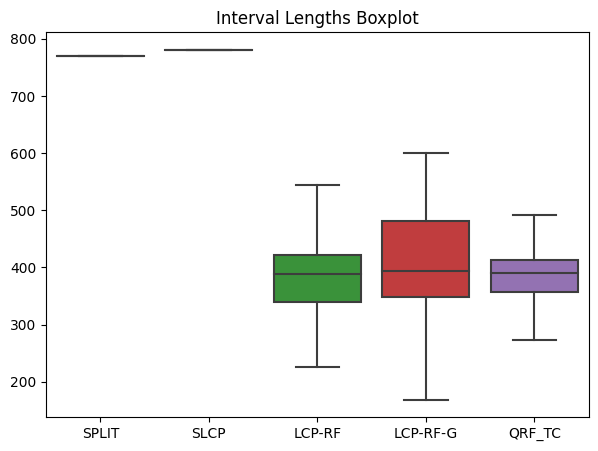

In [21]:
fig, ax = plt.subplots(dpi=100, figsize=(7, 5))
g = sns.boxplot(data=r_data[methods], orient="v", ax=ax, showfliers = False,
           saturation=0.75, width=0.8, dodge=True, fliersize=5, linewidth=None, whis=1.5)
g.set_title('Interval Lengths Boxplot')
plt.show()

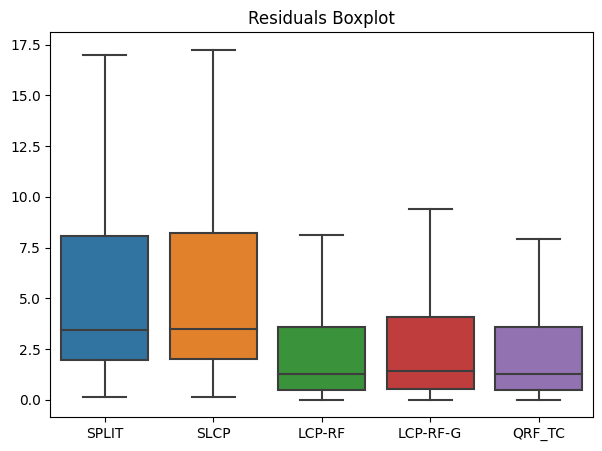

In [22]:
fig, ax = plt.subplots(dpi=100, figsize=(7, 5))
g = sns.boxplot(data=v_error[methods], orient="v", ax=ax, showfliers = False,
           saturation=0.75, width=0.8, dodge=True, fliersize=5, linewidth=None, whis=1.5)
g.set_title('Residuals Boxplot')
plt.show()